## Preparation

In [1]:
!pip install torch==1.9.0

In [2]:
import torch.nn as nn
import sys
import torch
from matplotlib import pyplot as plt
%matplotlib inline
torch.__version__

'1.9.0+cu102'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# For drive
path = "/content/drive/My Drive/project/"

sys.path.append(path + "URP")
sys.path.append(path + "URP/learning")
sys.path.append(path + "URP/data")
sys.path.append(path + "URP/models")
sys.path.append(path + "URP/forgetting")

In [5]:
# For PC
'''
path = ".."
sys.path.append(path)
sys.path.append(path + "/learning")
sys.path.append(path + "/data")
sys.path.append(path + "/models")
sys.path.append(path + "/forgetting")
'''

'\npath = ".."\nsys.path.append(path)\nsys.path.append(path + "/learning")\nsys.path.append(path + "/data")\nsys.path.append(path + "/models")\nsys.path.append(path + "/forgetting")\n'

In [6]:
from data_utils import *#show_random, AddNoise, remove_random, remove_class, combine_datasets
from data import get_dataset, dummy_clusters, dummy_half_doughnuts
from models_utils import *
import models
from learn import *
from forget import *
from forget import FD
from utils import set_seed

In [7]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

SEED SET TO:  13


device(type='cuda', index=0)

##Models and Datasets

In [8]:
cifar10_train, cifar10_val, cifar10_test = get_dataset("cifar10", batch_size=32, cuda=0,
                  train_size=10000, val_size=2000, test_size=1000,
                  test_batch_size=32)
print('-'*20)

cnn = {"filters_percentage": 1, "n_channels":3,"num_classes": 50, "dropout": True, "batch_norm": True}
cnn_model = get_model("cnn", **cnn)
print(cnn_model.__class__.__name__)
print('-'*20)

#cnn_model_retrain = copy.deepcopy(cnn_model)
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
_ = test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=cifar10_test, at_epoch=None)

Files already downloaded and verified
Dataset sizes: 	 train: 10000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
CNN
--------------------
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.9684426188468933
Error:  0.125
FINISHED TESTING


In [9]:
mnist_train, mnist_val, mnist_test = get_dataset("mnist", batch_size=32, cuda=0,
                  train_size=10000, val_size=2000, test_size=1000,
                  test_batch_size=32)
print('-'*20)

dnn = {"input_size": 1024, "hidden_size":64, "num_classes":10,"num_layer": 10, "activation": nn.ReLU()}
dnn_model = get_model("mlp", **dnn)
print(dnn_model.__class__.__name__)
print('-'*20)

checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
_ = test(model=dnn_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='mnist', test_loader=mnist_test, at_epoch=None)

Dataset sizes: 	 train: 10000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
MLP
--------------------
SEED SET TO:  13
Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.02780456840991974
Error:  0.0
FINISHED TESTING


In [10]:
cifar100_train, cifar100_val, cifar100_test = get_dataset("cifar100", batch_size=32, cuda=0,
                  train_size=20000, val_size=2000, test_size=1000,
                  test_batch_size=10)
print('-'*20)

resnet18 = {"filters_percentage": 0.4, "n_channels":3,"num_classes": 100, "block": ResBlock, "num_blocks": [2,2,2,2]}
resnet18_model = get_model("resnet18", **resnet18)
print(resnet18_model.__class__.__name__)
print('-'*20)

checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
_ = test(model=resnet18_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='cifar', test_loader=cifar100_test, at_epoch=None)

Files already downloaded and verified
Dataset sizes: 	 train: 20000 	 val: 2000 	 test: 1000
Batch size: 	 32
--------------------
ResNet18
--------------------
SEED SET TO:  13
Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  3.240086317062378
Error:  0.5
FINISHED TESTING


## My methods

### Forget class

#### Feature Destruction

SEED SET TO:  13
--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7173795104026794
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
FORGETTING PROCESS
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.6117392182350159, "error": 0.25}
[0] test metrics:{"loss": 3.789520263671875, "error": 0.9354838728904724}
Epoch number: 0 
Epoch Time: 5.56 sec
[1] train metrics:{"loss": 0.2447914034128189, "error": 0.125}
[1] test metrics:{"loss": 3.7732303142547607, "error": 0.9032258093357086}
Epoch number: 1 
Epoch Time: 5.68 sec
[2] train metrics:{"loss": 0.21970295906066895, "error": 0.0625}
[2] test metrics:{"loss": 4.110043525695801, "

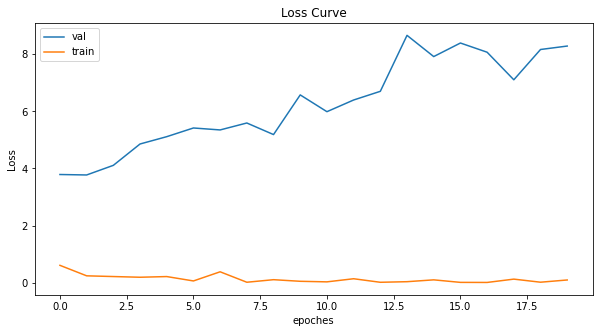

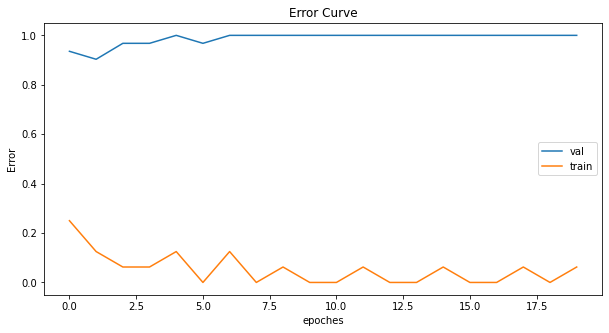

Forget time is: 107.58015942573547
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  8.283354759216309
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.1879037618637085
Error:  0.2222222089767456
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
#test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=cifar10_test, at_epoch=None)
#print('FORGETTING IMPLEMENTATION')
# All in one class
fd = FD(0, 0.1)
fd.forget_class(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

SEED SET TO:  13
--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.040489207953214645
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.042976465076208115
Error:  0.0
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.14638099074363708, "error": 0.0}
[0] test metrics:{"loss": 0.12570706009864807, "error": 0.0}
Epoch number: 0 
Epoch Time: 1.51 sec
[1] train metrics:{"loss": 0.09864956140518188, "error": 0.0}
[1] test metrics:{"loss": 0.34772947430610657, "error": 0.09999996423721313}
Epoch number: 1 
Epoch Time: 1.51 sec
[2] train metrics:{"loss": 0.09315334260463715, "error": 0.0}
[2] test metrics:{"loss": 0.3608624339103699, "error": 0.09999996423721313}
Epoch number: 2 
Epoch Time: 1.53 sec
[3] train metrics:{"loss"

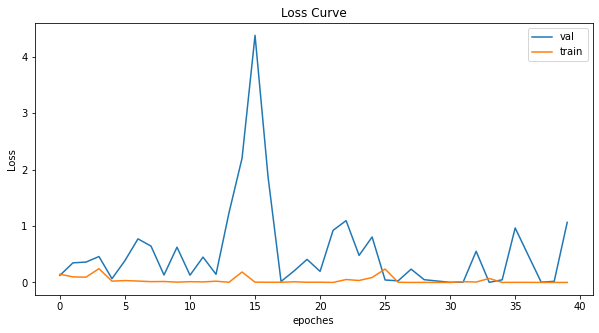

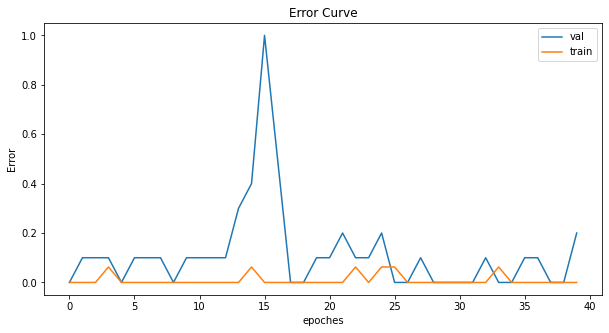

Forget time is: 60.74140954017639
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0659935474395752
Error:  0.19999998807907104
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.251282274723053
Error:  0.0666666030883789
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
# All in one function
fd.std = 1.4
fd.forget_class(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=40, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train, val_loader=mnist_test,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

SEED SET TO:  13
--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04636473208665848
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  3.59897780418396
Error:  0.5555555522441864
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 2.360914945602417, "error": 0.65625}
[0] test metrics:{"loss": 22.577272415161133, "error": 1.0}
Epoch number: 0 
Epoch Time: 18.87 sec
[1] train metrics:{"loss": 2.2571864128112793, "error": 0.5625}
[1] test metrics:{"loss": 9.593591690063477, "error": 1.0}
Epoch number: 1 
Epoch Time: 18.96 sec
[2] train metrics:{"loss": 1.880025029182434, "error": 0.4375}
[2] test metrics:{"loss": 9.052413940429688, "error": 1.0}
Epoch number: 2 
Epoch Time: 18.9 sec
[3] train metrics:{"loss": 1.3338857889

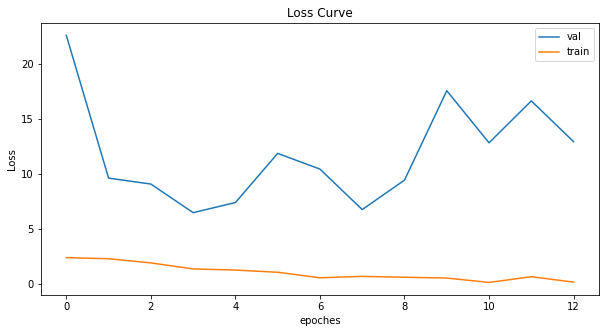

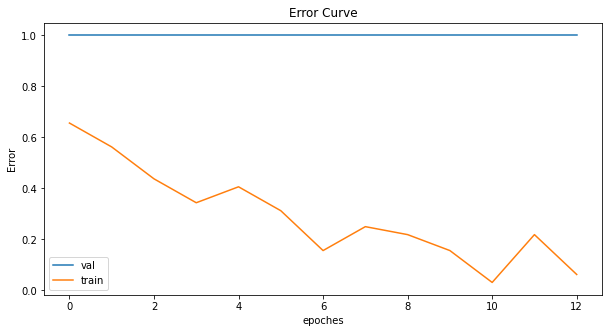

Forget time is: 245.45979642868042
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  12.906329154968262
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  3.4053475856781006
Error:  0.6666666567325592
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
#test(model=resnet18_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='cifar', test_loader=cifar100_test, at_epoch=None)
#print('FORGETTING IMPLEMENTATION')
# All in one function
fd.std = 0.4
fd.forget_class(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train, val_loader=cifar100_test,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

#### Negative Information Allocation

--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.044868238270282745
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.0394032821059227
Error:  0.0
FINISHED TESTING
--------------------
TRAINING ENCODER
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.027904272079467773, "error": 0.0}
[0] test metrics:{"loss": 0.006949358619749546, "error": 0.0}
Epoch number: 0 
Epoch Time: 0.43 sec
[1] train metrics:{"loss": 0.027746817097067833, "error": 0.0}
[1] test metrics:{"loss": 0.006869225762784481, "error": 0.0}
Epoch number: 1 
Epoch Time: 0.41 sec
[2] train metrics:{"loss": 0.027720939368009567, "error": 0.0}
[2] test metrics:{"loss": 0.006856570951640606, "error": 0.0}
Epoch number: 2 
Epoch Time: 0.41 sec
[3] train metrics:{"loss": 0.02770942822098732, "error": 0.0}
[3] test 

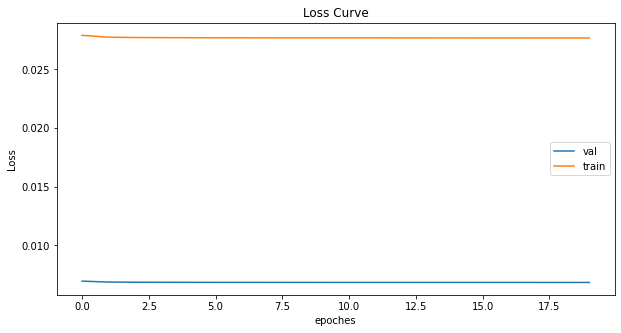

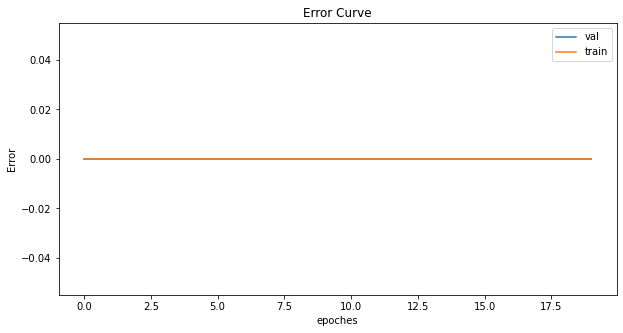

--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.6735949516296387, "error": 0.1875}
[0] test metrics:{"loss": 2.9004130363464355, "error": 0.5999999940395355}
Epoch number: 0 
Epoch Time: 6.73 sec
[1] train metrics:{"loss": 0.1791941374540329, "error": 0.0625}
[1] test metrics:{"loss": 1.7304041385650635, "error": 0.5999999940395355}
Epoch number: 1 
Epoch Time: 6.69 sec
[2] train metrics:{"loss": 0.557083249092102, "error": 0.125}
[2] test metrics:{"loss": 4.5175371170043945, "error": 0.7999999970197678}
INFO: Early stopping counter 1 of 7
Epoch number: 2 
Epoch Time: 6.69 sec
[3] train metrics:{"loss": 0.518084704875946, "error": 0.1875}
[3] test metrics:{"loss": 3.29011607170105, "error": 0.7999999970197678}
INFO: Early stopping counter 2 of 7
Epoch number: 3 
Epoch Time: 6.69 sec
[4] train metrics:{"loss": 0.2627442181110382, "error": 0.125}
[4] test metrics:{"loss": 4.31384181976318

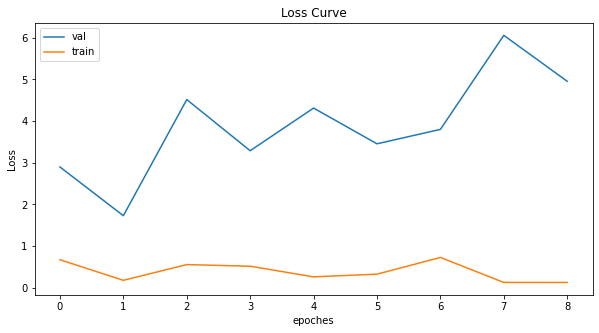

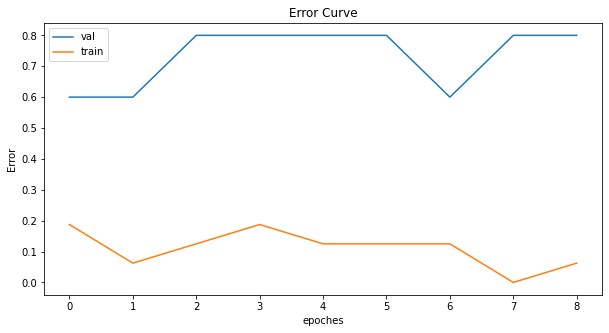

Forget time is: 60.684927225112915
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  4.956639289855957
Error:  0.7999999970197678
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.008808122016489506
Error:  0.0
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])

# All in one class
nia = NIA()
#print(nia.encoder_model)
model = nia.forget_class(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_val,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.32783040404319763
Error:  0.05263155698776245
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.25657379627227783
Error:  0.06896549463272095
FINISHED TESTING
--------------------
TRAINING ENCODER
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.06251802295446396, "error": 0.027027010917663574}
[0] test metrics:{"loss": 0.06000590696930885, "error": 0.03921562433242798}
Epoch number: 0 
Epoch Time: 0.12 sec
[1] train metrics:{"loss": 0.06251802295446396, "error": 0.027027010917663574}
[1] test metrics:{"loss": 0.06000590696930885, "error": 0.03921562433242798}
Epoch number: 1 
Epoch Time: 0.12 sec
[2] train metrics:{"loss": 0.06251802295446396, "error": 0.027027010917663574}
[2] test metrics:{"loss": 0

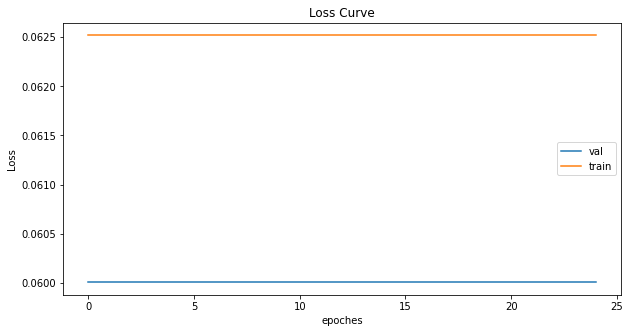

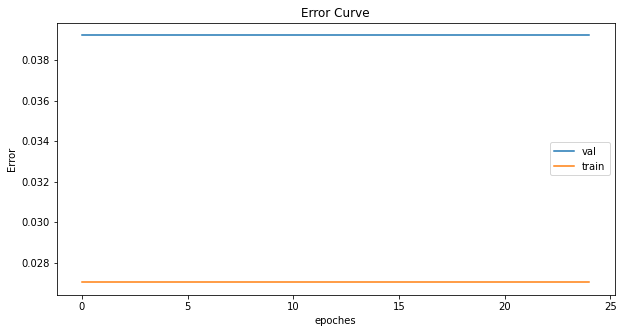

--------------------
FORGETTING PROCESS
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.16426235437393188, "error": 0.0625}
[0] test metrics:{"loss": 1.3438594341278076, "error": 0.2631579041481018}
Epoch number: 0 
Epoch Time: 2.82 sec
[1] train metrics:{"loss": 0.051725149154663086, "error": 0.0}
[1] test metrics:{"loss": 1.2049461603164673, "error": 0.2631579041481018}
Epoch number: 1 
Epoch Time: 3.09 sec
[2] train metrics:{"loss": 0.11937425285577774, "error": 0.0625}
[2] test metrics:{"loss": 1.5573108196258545, "error": 0.3684210777282715}
Epoch number: 2 
Epoch Time: 3.15 sec
[3] train metrics:{"loss": 0.07890014350414276, "error": 0.0}
[3] test metrics:{"loss": 2.8607959747314453, "error": 0.6842105388641357}
Epoch number: 3 
Epoch Time: 2.83 sec
[4] train metrics:{"loss": 0.0038469277787953615, "error": 0.0}
[4] test metrics:{"loss": 2.5695912837982178, "error": 0.5789473652839661}
Epoch number: 4 


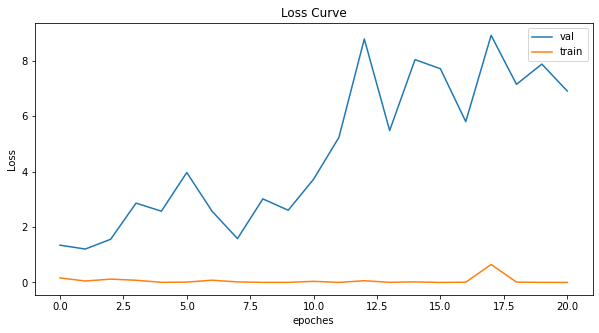

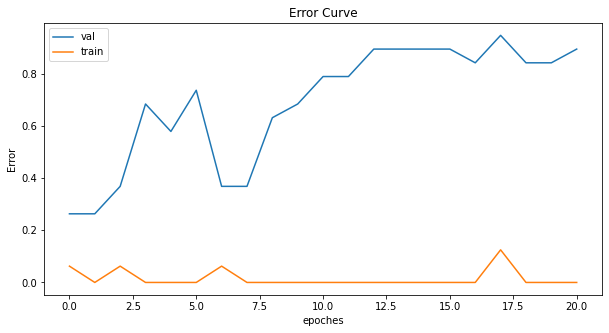

Forget time is: 62.63188362121582
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  6.904369831085205
Error:  0.8947368413209915
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7089560031890869
Error:  0.06896549463272095
FINISHED TESTING


In [11]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])

# All in one class
nia = NIA()
#print(nia.encoder_model)
model = nia.forget_class(class_id=1, model=dnn_model, loss='ce', optimizer='adam', epochs=25, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train, val_loader=mnist_val,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04123486950993538
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04855159670114517
Error:  0.03333330154418945
FINISHED TESTING
--------------------
TRAINING ENCODER
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 0.8742995858192444, "error": 0.1794871687889099}
[0] test metrics:{"loss": 1.423305630683899, "error": 0.24000000953674316}
Epoch number: 0 
Epoch Time: 0.06 sec
[1] train metrics:{"loss": 0.0641363263130188, "error": 0.0}
[1] test metrics:{"loss": 0.2033359855413437, "error": 0.020000040531158447}
Epoch number: 1 
Epoch Time: 0.06 sec
[2] train metrics:{"loss": 0.05143391340970993, "error": 0.0}
[2] test metrics:{"loss": 0.12976382672786713, "error": 0.020000040531158447}


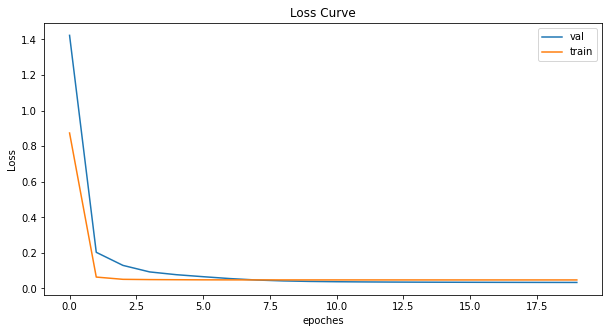

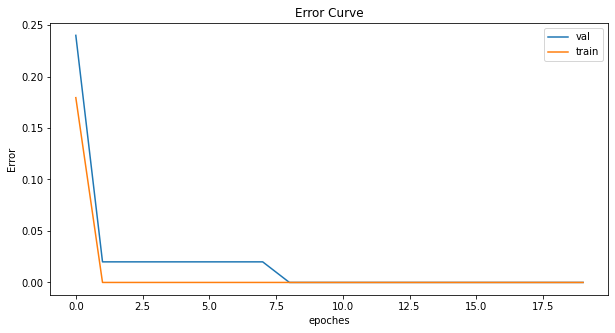

--------------------
FORGETTING PROCESS
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 2.8881592750549316, "error": 0.6875}
[0] test metrics:{"loss": 7.519705772399902, "error": 1.0}
Epoch number: 0 
Epoch Time: 9.2 sec
[1] train metrics:{"loss": 1.9403340816497803, "error": 0.53125}
[1] test metrics:{"loss": 9.649876594543457, "error": 1.0}
INFO: Early stopping counter 1 of 10
Epoch number: 1 
Epoch Time: 9.48 sec
[2] train metrics:{"loss": 1.4130055904388428, "error": 0.34375}
[2] test metrics:{"loss": 13.06328296661377, "error": 1.0}
INFO: Early stopping counter 2 of 10
Epoch number: 2 
Epoch Time: 9.22 sec
[3] train metrics:{"loss": 1.5547150373458862, "error": 0.4375}
[3] test metrics:{"loss": 8.709336280822754, "error": 1.0}
Epoch number: 3 
Epoch Time: 9.06 sec
[4] train metrics:{"loss": 2.0759739875793457, "error": 0.4375}
[4] test metrics:{"loss": 11.857576370239258, "error": 1.0}
INFO: Early sto

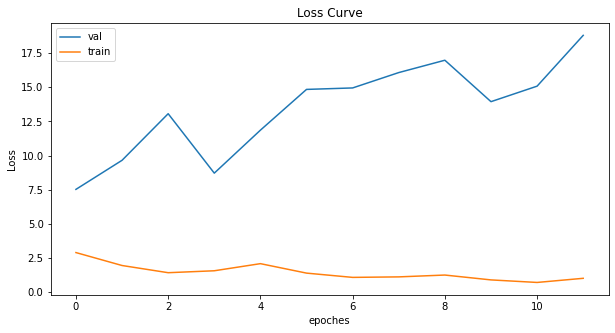

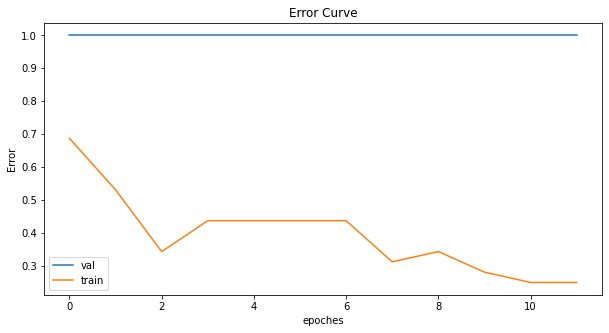

Forget time is: 111.24110841751099
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  18.8054256439209
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.562699556350708
Error:  0.36666661500930786
FINISHED TESTING


In [11]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])

# All in one class
nia = NIA()
#print(nia.encoder_model)
model = nia.forget_class(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train, val_loader=cifar100_val,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

### Forget image

#### Feature Destruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label tensor(3)


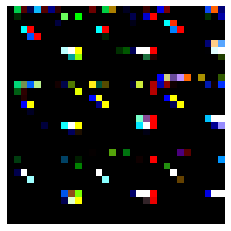

In [ ]:
img, lab = get_random_img(cifar10_train)
img = img.view(32, 32, -1)
plt.axis("off")
print("Label", lab)
plt.imshow(img)

SEED SET TO:  13
--------------------
True label is:  tensor(3)
Predicted label is:  tensor(3, device='cuda:0')
--------------------
INITIAL D PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.16268913447856903
Error:  0.0625
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.9666451215744019, "error": 0.0}
[0] test metrics:{"loss": 0.02824249491095543, "error": 0.0}
Epoch number: 0 
Epoch Time: 4.96 sec
[1] train metrics:{"loss": 0.685254693031311, "error": 0.0}
[1] test metrics:{"loss": 0.049447860568761826, "error": 0.0}
Epoch number: 1 
Epoch Time: 5.01 sec
[2] train metrics:{"loss": 0.49935001134872437, "error": 0.0}
[2] test metrics:{"loss": 0.036819931119680405, "error": 0.0}
Epoch number: 2 
Epoch Time: 4.95 sec
[3] train metrics:{"loss": 0.3426664471626282, "error": 0.0}
[3] test metrics:{"loss": 0.037579141557216644, "error": 0.0}


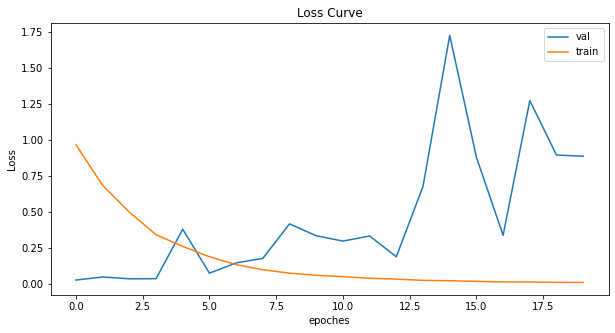

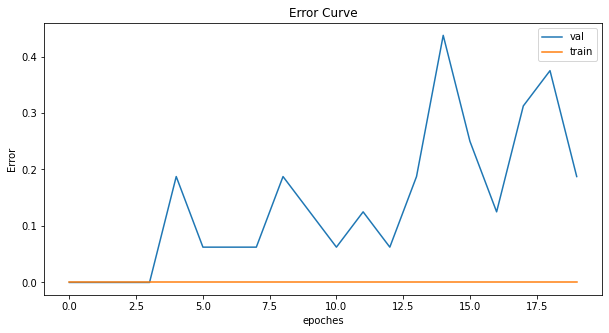

Forget time is: 99.74941682815552
--------------------
FINAL D PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.4160001277923584
Error:  0.375
FINISHED TESTING
--------------------
True label is:  tensor(3)
Predicted label is:  tensor(3, device='cuda:0')


In [ ]:
img = img.view(-1, 32, 32)
imglab = (img, lab)

fd = FD(0, 0.1)
#plab = predict(cnn_model, img, device)
#print(plab)
fd.forget_image(imglab=imglab, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, ds=cifar10_train,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

SEED SET TO:  13
--------------------
True label is:  tensor(4)
Predicted label is:  tensor(4, device='cuda:0')
--------------------
INITIAL D PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.5963973999023438
Error:  0.25
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 60.791412353515625, "error": 1.0}
[0] test metrics:{"loss": 0.514473021030426, "error": 0.3125}
Epoch number: 0 
Epoch Time: 2.23 sec
[1] train metrics:{"loss": 40.329288482666016, "error": 1.0}
[1] test metrics:{"loss": 0.23272046446800232, "error": 0.0625}
Epoch number: 1 
Epoch Time: 2.27 sec
[2] train metrics:{"loss": 23.053686141967773, "error": 1.0}
[2] test metrics:{"loss": 0.44184234738349915, "error": 0.125}
Epoch number: 2 
Epoch Time: 2.27 sec
[3] train metrics:{"loss": 17.13546371459961, "error": 1.0}
[3] test metrics:{"loss": 1.3071657419204712, "error": 0.3125}

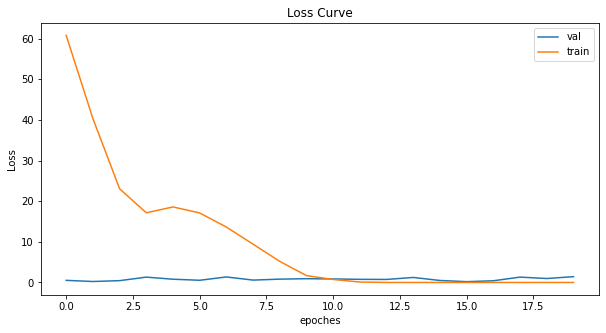

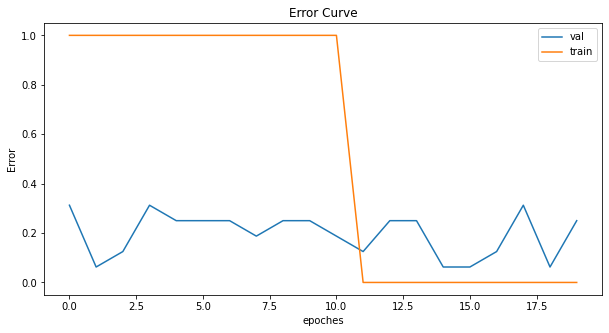

Forget time is: 45.82728862762451
--------------------
FINAL D PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.3992045819759369
Error:  0.1875
FINISHED TESTING
--------------------
True label is:  tensor(4)
Predicted label is:  tensor(4, device='cuda:0')


In [ ]:
imglab = get_random_img(mnist_train)
fd = FD(0, 1.5)
#plab = predict(cnn_model, img, device)
#print(plab)
fd.forget_image(imglab=imglab, model=dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, ds=mnist_train,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

### Forget subset of data

SEED SET TO:  13
--------------------
INITIAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.13061264157295227
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.22685614228248596
Error:  0.09090906381607056
FINISHED TESTING
--------------------
FORGETTING PROCESS
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.6101464629173279, "error": 0.25}
[0] test metrics:{"loss": 0.3339564800262451, "error": 0.09090906381607056}
Epoch number: 0 
Epoch Time: 7.53 sec
[1] train metrics:{"loss": 0.3465399742126465, "error": 0.125}
[1] test metrics:{"loss": 0.16162799298763275, "error": 0.0}
Epoch number: 1 
Epoch Time: 7.58 sec
[2] train metrics:{"loss": 0.2821580767631531, "error": 0.0625}
[2] test metrics:{"loss": 0.20408053696155548, "error": 0.09090906381607056}
Epoch number: 2 
Epoch Time: 7.54 sec
[3] trai

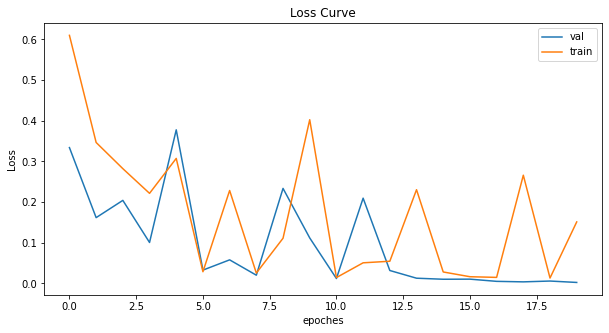

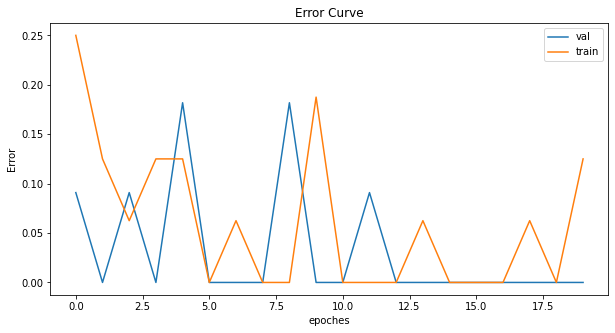

Forget time is: 151.22017550468445
--------------------
FINAL Df PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.06528151035308838
Error:  0.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.0021383771672844887
Error:  0.0
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])

fd = FD(1, 2.0)
fd.forget_subset(img_num=200, class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train,
    scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

### Retrain

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.044820401817560196
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.03935350850224495
Error:  0.0
FINISHED TESTING
--------------------
RETRAINING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 1.1796088218688965, "error": 0.3333333134651184}
[0] test metrics:{"loss": 8.178454399108887, "error": 1.0}
Epoch number: 0 
Epoch Time: 2.8 sec
[1] train metrics:{"loss": 0.6825025677680969, "error": 0.0}
[1] test metrics:{"loss": 9.471518516540527, "error": 1.0}
Epoch number: 1 
Epoch Time: 2.82 sec
[2] train metrics:{"loss": 0.5240666270256042, "error": 0.0}
[2] test metrics:{"loss": 10.602323532104492, "error": 1.0}
Epoch number: 2 
Epoch Time: 2.79 sec
[3] train metrics:{"loss"

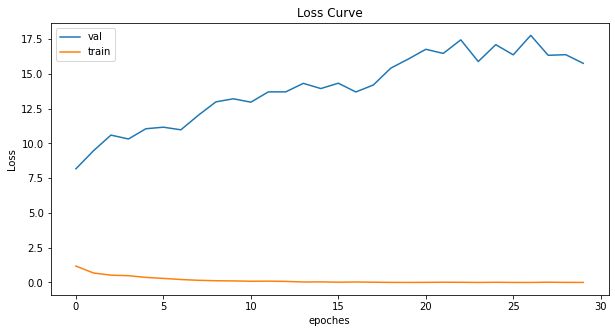

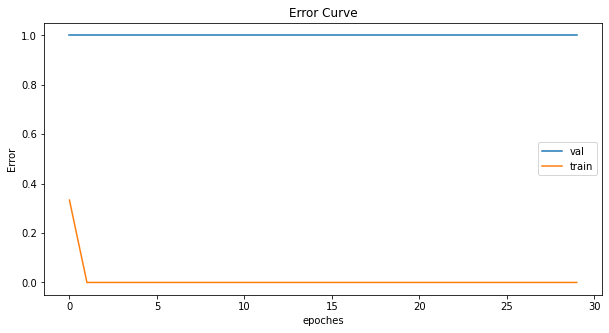

Forget time is: 83.50179934501648
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  15.766413688659668
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.15555129945278168
Error:  0.09090906381607056
FINISHED TESTING


In [12]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
retrain(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=30, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train,
    val_loader=cifar10_val, scheduler=None, weight_decay=0.0, lr=0.0003, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09932907670736313
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.8630432486534119
Error:  0.25
FINISHED TESTING
--------------------
RETRAINING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 2.2139313220977783, "error": 0.7916666567325592}
[0] test metrics:{"loss": 5.686866760253906, "error": 1.0}
Epoch number: 0 
Epoch Time: 1.45 sec
[1] train metrics:{"loss": 2.1549758911132812, "error": 0.9166666641831398}
[1] test metrics:{"loss": 13.633028030395508, "error": 1.0}
INFO: Early stopping counter 1 of 100
Epoch number: 1 
Epoch Time: 1.42 sec
[2] train metrics:{"loss": 1.743992805480957, "error": 0.6666666567325592}
[2] test metrics:{"loss": 29.51654815673828, "error": 1

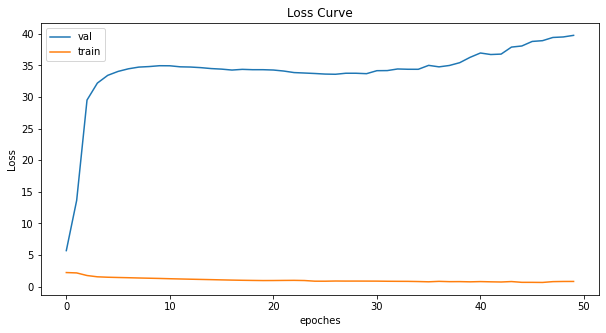

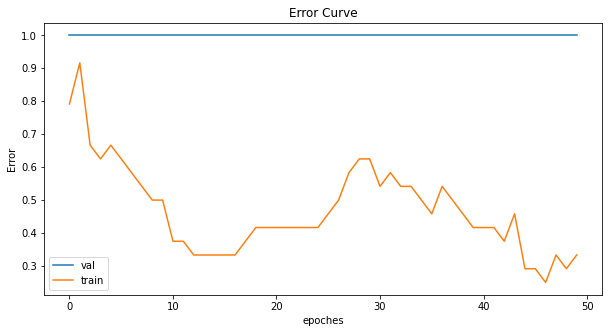

Forget time is: 72.20480179786682
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  39.75444793701172
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  2.1888928413391113
Error:  0.5
FINISHED TESTING


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
retrain(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=51, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train,
    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04123486950993538
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04855159670114517
Error:  0.03333330154418945
FINISHED TESTING
--------------------
RETRAINING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 3.98001766204834, "error": 0.8400000035762787}
[0] test metrics:{"loss": 8.793103218078613, "error": 1.0}
Epoch number: 0 
Epoch Time: 9.11 sec
[1] train metrics:{"loss": 3.83420991897583, "error": 0.8400000035762787}
[1] test metrics:{"loss": 9.699860572814941, "error": 1.0}
Epoch number: 1 
Epoch Time: 8.77 sec
[2] train metrics:{"loss": 3.744032382965088, "error": 0.9200000017881393}
[2] test metrics:{"loss": 10.581368446350098, "error": 1.0}
Epoch number: 2 


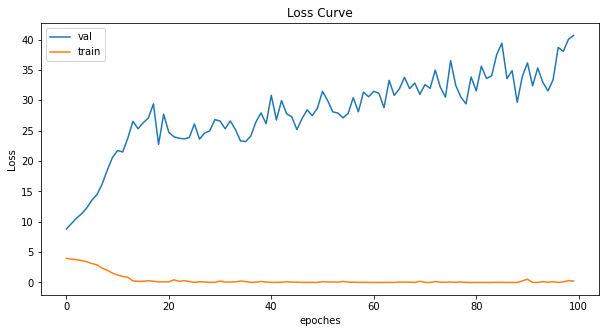

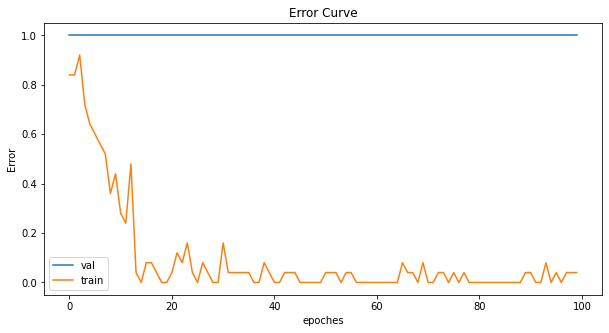

Forget time is: 892.6801857948303
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  40.69384765625
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  4.293553352355957
Error:  0.3999999761581421
FINISHED TESTING


In [13]:
retrain(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=100, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train,
    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

##Classical methods

###Finetune

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7173795104026794
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
FINETUNING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.19962942600250244, "error": 0.0}
[0] test metrics:{"loss": 1.2180438041687012, "error": 0.29032260179519653}
Epoch number: 0 
Epoch Time: 2.77 sec
[1] train metrics:{"loss": 0.1436164230108261, "error": 0.0}
[1] test metrics:{"loss": 1.6894044876098633, "error": 0.4838709831237793}
Epoch number: 1 
Epoch Time: 2.89 sec
[2] train metrics:{"loss": 0.010081700049340725, "error": 0.0}
[2] test metrics:{"loss": 1.9715728759765625, "error": 0.4838709831237793

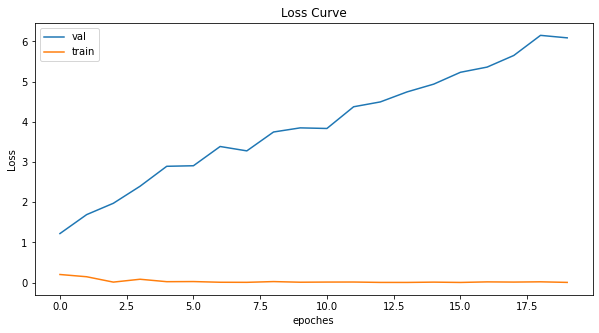

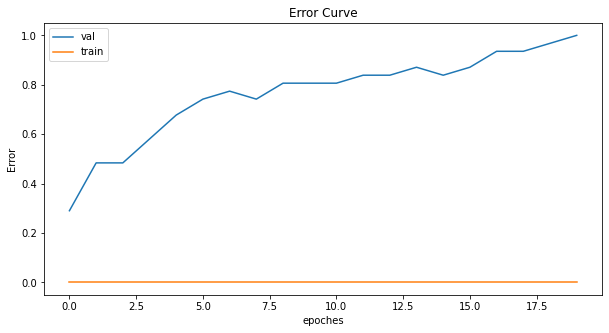

Forget time is: 56.07414364814758
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  6.08799409866333
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.3406730890274048
Error:  0.4444444179534912
FINISHED TESTING


In [14]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
fine_tune(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.0001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09930070489645004
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.8636372089385986
Error:  0.25
FINISHED TESTING
--------------------
FINETUNING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.169785276055336, "error": 0.08333331346511841}
[0] test metrics:{"loss": 1.0101162195205688, "error": 0.375}
Epoch number: 0 
Epoch Time: 1.47 sec
[1] train metrics:{"loss": 0.06025351956486702, "error": 0.0}
[1] test metrics:{"loss": 1.5666589736938477, "error": 0.75}
Epoch number: 1 
Epoch Time: 1.27 sec
[2] train metrics:{"loss": 0.012740989215672016, "error": 0.0}
[2] test metrics:{"loss": 2.770801544189453, "error": 1.0}
Epoch number: 2 
Epoch Time: 1.27 sec
[3] train metrics:

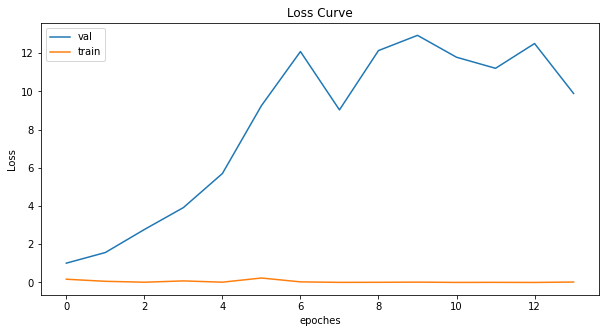

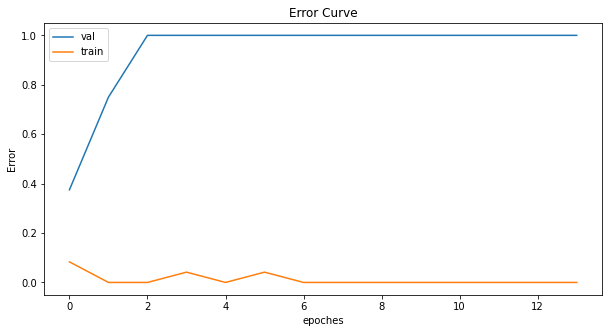

Forget time is: 19.06157875061035
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  9.890647888183594
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.6228923201560974
Error:  0.125
FINISHED TESTING


In [15]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
fine_tune(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train,
    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04123486950993538
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04855159670114517
Error:  0.03333330154418945
FINISHED TESTING
--------------------
FINETUNING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 2.622218370437622, "error": 0.6400000154972076}
[0] test metrics:{"loss": 10.559650421142578, "error": 1.0}
Epoch number: 0 
Epoch Time: 9.52 sec
[1] train metrics:{"loss": 2.276794195175171, "error": 0.5600000023841858}
[1] test metrics:{"loss": 15.103140830993652, "error": 1.0}
INFO: Early stopping counter 1 of 10
Epoch number: 1 
Epoch Time: 9.56 sec
[2] train metrics:{"loss": 1.8327996730804443, "error": 0.40000003576278687}
[2] test metrics:{"loss": 16.08709

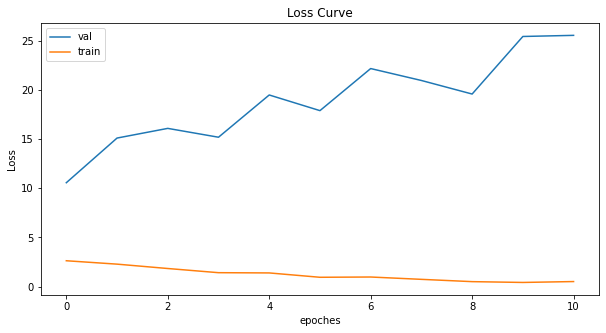

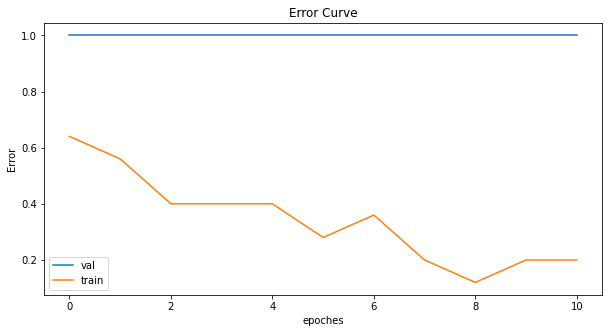

Forget time is: 99.55727791786194
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  25.550451278686523
Error:  1.0
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  2.046522617340088
Error:  0.36666661500930786
FINISHED TESTING


In [16]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
fine_tune(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train,
    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

### Random labels

In [20]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
random_labels(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.0001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7173795104026794
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
RANDOMING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 0.028344660997390747, "error": 0.0}
[0] test metrics:{"loss": 1.5615534782409668, "error": 0.3870967626571655}
Epoch number: 0 :
 Epoch Time: 2.77 sec
[1] train metrics:{"loss": 0.05323857069015503, "error": 0.0}
[1] test metrics:{"loss": 2.145031213760376, "error": 0.5483871102333069}
Epoch number: 1 :
 Epoch Time: 2.79 sec
[2] train metrics:{"loss": 0.012382502667605877, "error": 0.0}
[2] test metrics:{"loss": 2.4218010902404785, "error": 0.6129032373428

In [21]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
random_labels(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train,
    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09930070489645004
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.8636372089385986
Error:  0.25
FINISHED TESTING
--------------------
RANDOMING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.169785276055336, "error": 0.08333331346511841}
[0] test metrics:{"loss": 1.0101162195205688, "error": 0.375}
Epoch number: 0 :
 Epoch Time: 1.3 sec
[1] train metrics:{"loss": 0.06025351956486702, "error": 0.0}
[1] test metrics:{"loss": 1.5666589736938477, "error": 0.75}
Epoch number: 1 :
 Epoch Time: 1.35 sec
[2] train metrics:{"loss": 0.012740989215672016, "error": 0.0}
[2] test metrics:{"loss": 2.770801544189453, "error": 1.0}
Epoch number: 2 :
 Epoch Time: 1.25 sec
[3] train metr

In [22]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
random_labels(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train,
    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04123486950993538
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04855159670114517
Error:  0.03333330154418945
FINISHED TESTING
--------------------
RANDOMING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 2.622218370437622, "error": 0.6400000154972076}
[0] test metrics:{"loss": 10.559650421142578, "error": 1.0}
Epoch number: 0 :
 Epoch Time: 8.86 sec
[1] train metrics:{"loss": 2.276794195175171, "error": 0.5600000023841858}
[1] test metrics:{"loss": 15.103140830993652, "error": 1.0}
Epoch number: 1 :
 Epoch Time: 8.63 sec
[2] train metrics:{"loss": 1.8327996730804443, "error": 0.40000003576278687}
[2] test metrics:{"loss": 16.087095260620117, "error": 1.0}
Epoch nu

### Hiding

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7173795104026794
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
HIDING
SEED SET TO:  13
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in Sequential_training]
[0] train metrics:{"loss": 1.154746413230896, "error": 0.3333333134651184}
[0] test metrics:{"loss": 5.556830406188965, "error": 1.0}
Epoch number: 0 
Epoch Time: 2.84 sec
[1] train metrics:{"loss": 0.7866267561912537, "error": 0.3333333134651184}
[1] test metrics:{"loss": 6.580369472503662, "error": 1.0}
Epoch number: 1 
Epoch Time: 2.8 sec
[2] train metrics:{"loss": 0.449955016374588, "error": 0.0}
[2] test metrics:{"loss": 7.137643814086914, "error": 1.0}
Epo

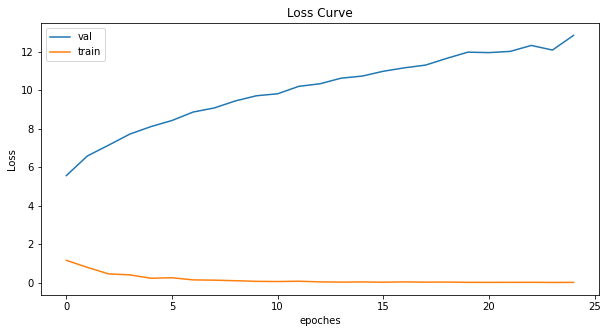

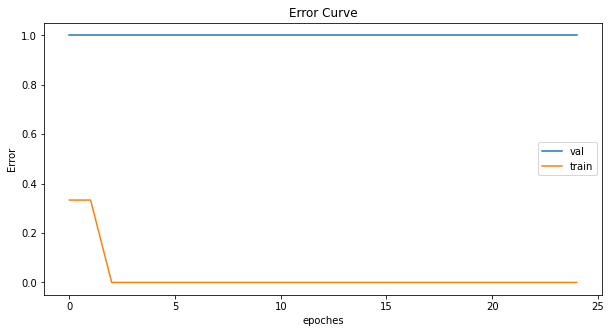

Forget time is: 69.61388754844666
--------------------
FINAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  2.9215505123138428
Error:  0.6451613008975983
FINISHED TESTING
--------------------
FINAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.3743442893028259
Error:  0.2222222089767456
FINISHED TESTING


In [24]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
hiding(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=25, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.0001, momentum=0.)

In [16]:
'''
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
hiding(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train,
    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)
'''

'\ncheckpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")\ndnn_model.load_state_dict(checkpoint[\'model\'])\nhiding(class_id=0, model=dnn_model, loss=\'ce\', optimizer=\'adam\', epochs=20, device=device, dataset=\'mnist\', lossfn=None, train_loader=mnist_train,\n    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)\n'

In [17]:
'''
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
hiding(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train,
    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)
'''

'\ncheckpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")\nresnet18_model.load_state_dict(checkpoint[\'model\'])\nhiding(class_id=0, model=resnet18_model, loss=\'ce\', optimizer=\'adam\', epochs=20, device=device, dataset=\'cifar\', lossfn=None, train_loader=cifar100_train,\n    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.001, momentum=0.)\n'

### Negative gradient

In [20]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{70}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
neg_gradient(class_id=0, model=cnn_model, loss='ce', optimizer='adam', epochs=25, device=device, dataset='cifar', lossfn=None, train_loader=cifar10_train, val_loader=cifar10_test,
    scheduler=None, weight_decay=0.0, lr=0.00001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.7173795104026794
Error:  0.19354844093322754
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.0722668170928955
Error:  0.2222222089767456
FINISHED TESTING
--------------------
ASCENDING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 21.178272247314453, "error": 1.0}
[0] test metrics:{"loss": 8.149834632873535, "error": 0.838709682226181}
Epoch number: 0 :
 Epoch Time: 0.33 sec
[1] train metrics:{"loss": 20.95929718017578, "error": 1.0}
[1] test metrics:{"loss": 8.759418487548828, "error": 0.838709682226181}
Epoch number: 1 :
 Epoch Time: 0.32 sec
[2] train metrics:{"loss": 20.76891326904297, "error": 1.0}
[2] test metrics:{"loss": 8.92363452911377, "error": 0.8064516186714172}
Epoch n

In [18]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{50}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])
neg_gradient(class_id=0, model=dnn_model, loss='ce', optimizer='adam', epochs=15, device=device, dataset='mnist', lossfn=None, train_loader=mnist_train,
    val_loader=mnist_val, scheduler=None, weight_decay=0.0, lr=0.0001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09930070489645004
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.8636372089385986
Error:  0.25
FINISHED TESTING
--------------------
ASCENDING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 10.282532691955566, "error": 1.0}
[0] test metrics:{"loss": 1.5989975929260254, "error": 0.5}
Epoch number: 0 :
 Epoch Time: 0.22 sec
[1] train metrics:{"loss": 4.747643947601318, "error": 1.0}
[1] test metrics:{"loss": 3.826019048690796, "error": 1.0}
Epoch number: 1 :
 Epoch Time: 0.2 sec
[2] train metrics:{"loss": 2.685227632522583, "error": 1.0}
[2] test metrics:{"loss": 5.082702159881592, "error": 1.0}
Epoch number: 2 :
 Epoch Time: 0.15 sec
[3] train metrics:{"loss": 1.789794325

In [17]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{resnet18_model.__class__.__name__}_{200}.pth.tar")
resnet18_model.load_state_dict(checkpoint['model'])
neg_gradient(class_id=0, model=resnet18_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset='cifar', lossfn=None, train_loader=cifar100_train,
    val_loader=cifar100_val, scheduler=None, weight_decay=0.0, lr=0.00001, momentum=0.)

--------------------
INITIAL Df PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04123486950993538
Error:  0.0
FINISHED TESTING
--------------------
INITIAL Dr PERFOMANCE
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.04855159670114517
Error:  0.03333330154418945
FINISHED TESTING
--------------------
ASCENDING
SEED SET TO:  13
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in ResNet18_training]
[0] train metrics:{"loss": 9.109033584594727, "error": 1.0}
[0] test metrics:{"loss": 6.114216327667236, "error": 0.7777777761220932}
Epoch number: 0 :
 Epoch Time: 0.11 sec
[1] train metrics:{"loss": 6.412865161895752, "error": 1.0}
[1] test metrics:{"loss": 15.343626022338867, "error": 1.0}
Epoch number: 1 :
 Epoch Time: 0.14 sec
[2] train metrics:{"loss": 4.0724005699157715, "error": 0.7142857015132904}
[2] test metrics:{"loss": 21.73226547241211, "error": 1.0}
Epoch number: 2 :
 Epoch T

### Download stuff

In [17]:
#save_state(cnn_model, set_optimizer('adam', cnn_model.parameters(), 0.001, 0.001, 0.8), './checkpoints/CNN_forget_20.pth.tar')
!ls ./checkpoints
from google.colab import files
files.download('./checkpoints/CNN_20.pth.tar')

CNN_20.pth.tar	MLP_14.pth.tar	      ResNet18_11.pth.tar
CNN_30.pth.tar	ResNet18_100.pth.tar


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
!ls checkpoints
from google.colab import files
files.download('./checkpoints/MLP_NIA25.pth.tar')

CNN_random_labels20.pth.tar  MLP_random_labels20.pth.tar
CNN_random_labels25.pth.tar  ResNet18_12.pth.tar
MLP_21.pth.tar		     ResNet18_NIA20.pth.tar
MLP_NIA25.pth.tar	     ResNet18_random_labels20.pth.tar
MLP_random_labels15.pth.tar


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>